# 使用随机森林预测

In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [22]:
print("TensorFlow v" + tf.__version__)

TensorFlow v2.15.0


In [23]:
train_file_path = "train.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (1460, 81)


In [24]:
dataset_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


### 去掉第一列id

In [25]:
dataset_df = dataset_df.drop('Id', axis=1)
dataset_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [26]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


C:\Users\白瑞\AppData\Local\Temp\ipykernel_9312\2675445600.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});#中文注释：distplot()函数绘制直方图


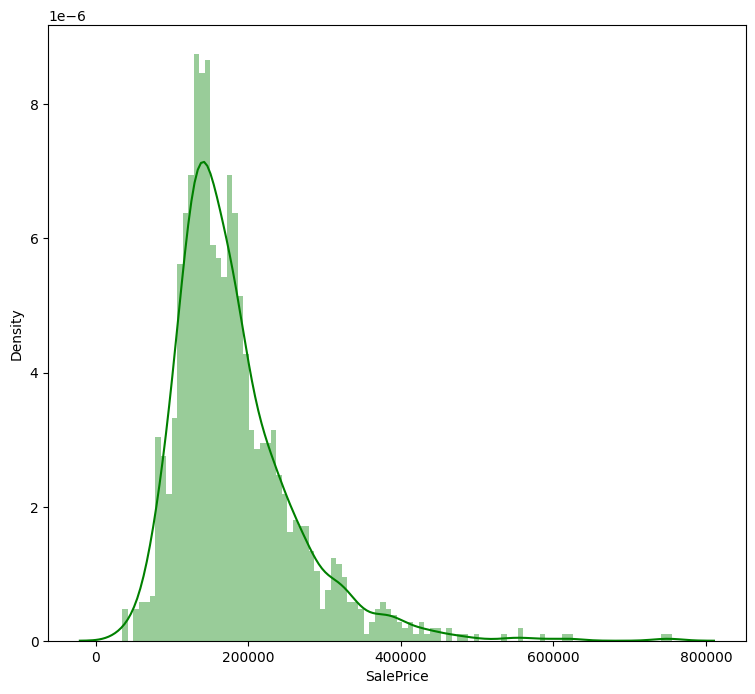

In [27]:
print(dataset_df['SalePrice'].describe())#中文注释：describe()函数自动计算非空值数，平均值，标准差，最小值，最大值，25%，50%，75%的数据
plt.figure(figsize=(9, 8))
sns.distplot(dataset_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});#中文注释：distplot()函数绘制直方图

## 观察数据分布
### 选择数值型数据

In [28]:
#将价格导入到csv文件中
dataset_df['SalePrice'].to_csv('price.csv', index=False)

In [29]:
list(set(dataset_df.dtypes.tolist()))

[dtype('float64'), dtype('O'), dtype('int64')]

In [30]:
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


### 画出各个数值数据的分布

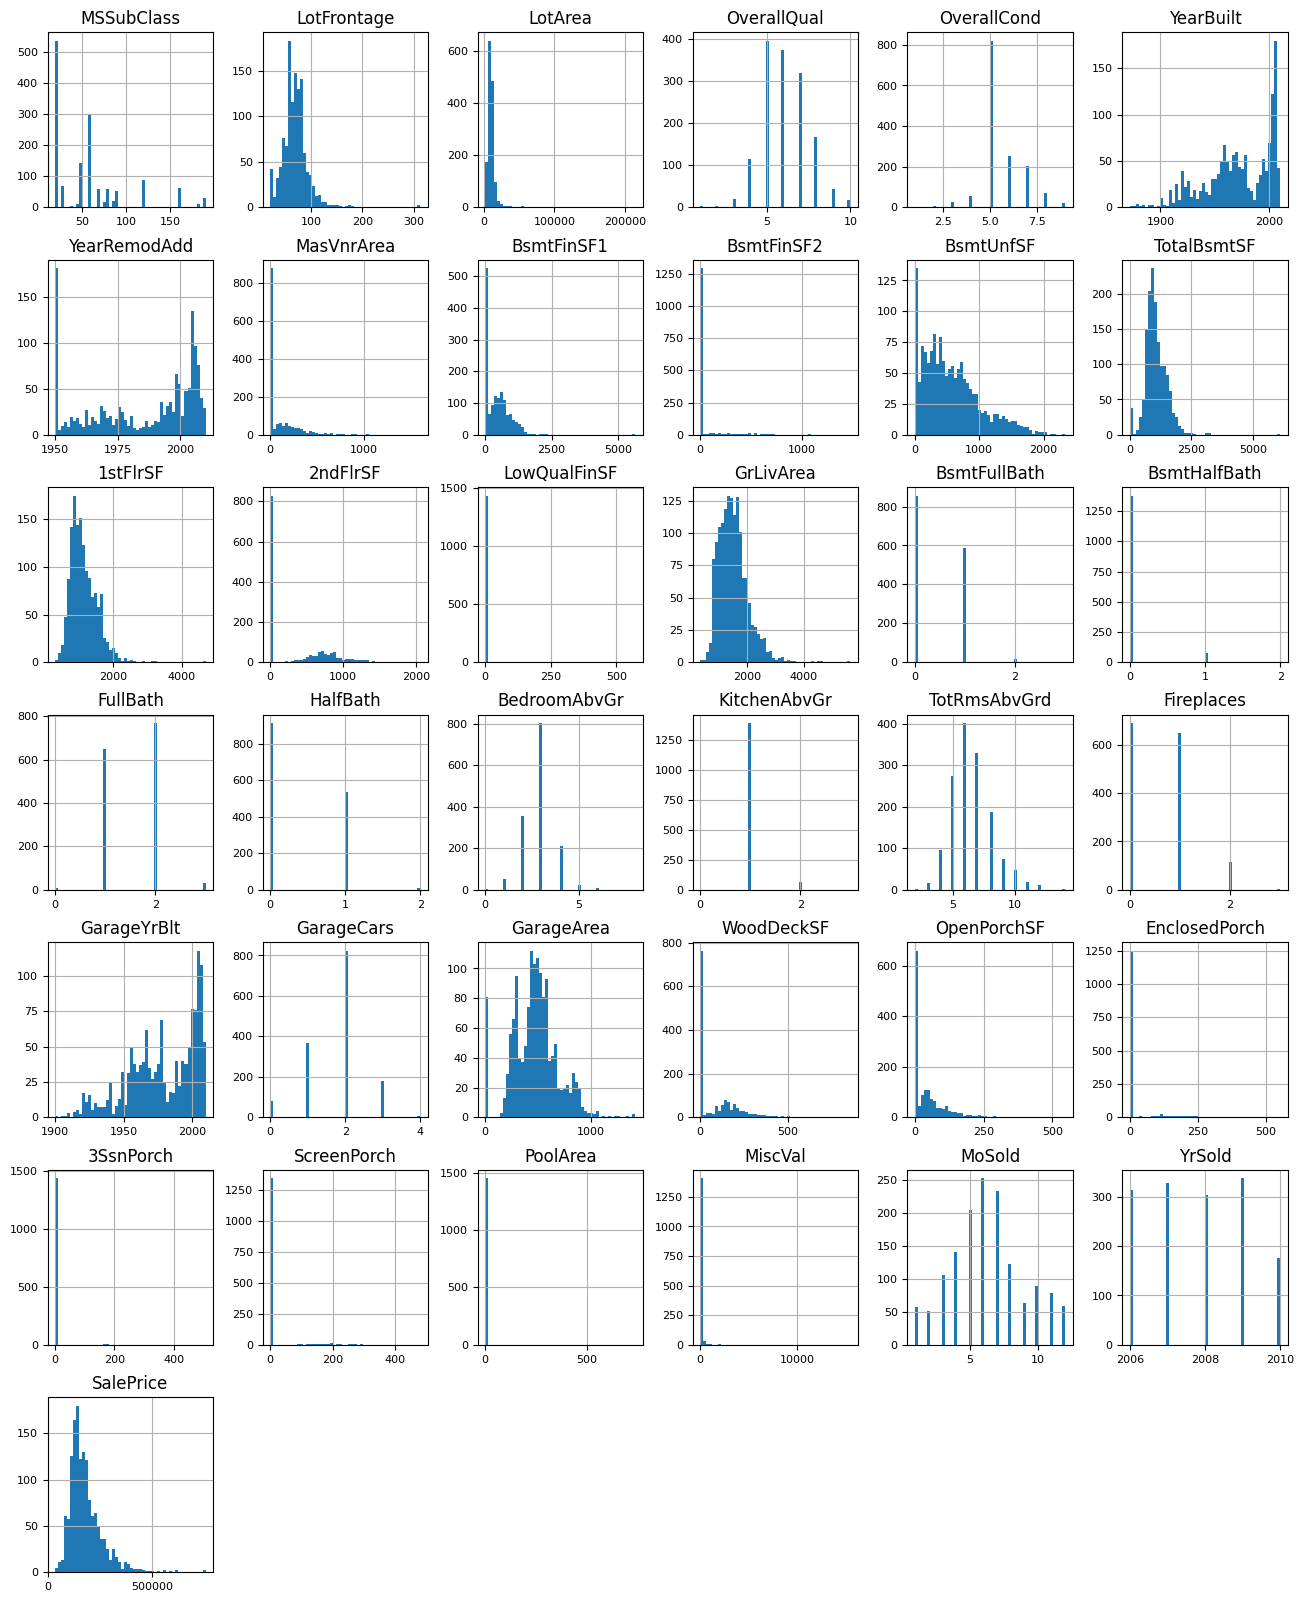

In [32]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);
#中文注释：hist()函数绘制直方图，figsize()函数设置图像大小，bins设置直方图的柱数，xlabelsize设置x轴标签字体大小，ylabelsize设置y轴标签字体大小
#将数据导入到csv文件中
df_num.to_csv('num.csv', index=False)

### 准备数据集
#### 该数据集包含数字、分类和缺失特征的混合。TF-DF本机支持所有这些特征类型，不需要预处理。这是基于树的模型的一个优点，使它们成为Tensorflow和ML的一个很好的切入点。

In [33]:
import numpy as np

#split_dataset()函数将数据集分为训练集和测试集
def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio #np.random.rand()函数返回一个或一组服从“0~1”均匀分布的随机样本值，len()函数返回对象长度或项目个数
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1012 examples in training, 448 examples in testing.


In [39]:
#使用随机森林算法
from sklearn.ensemble import RandomForestRegressor

#使用随机森林算法训练模型
rf = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=4, random_state=0)
rf.fit(train_ds_pd.drop('SalePrice', axis=1), train_ds_pd['SalePrice'])

#使用随机森林算法预测价格
predictions = rf.predict(valid_ds_pd.drop('SalePrice', axis=1))
errors = abs(predictions - valid_ds_pd['SalePrice'])
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

ValueError: could not convert string to float: 'RL'